In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
from PIL import Image
from torchvision.models import vgg19, VGG19_Weights

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_device(device)

# 1. data

## 1.1. load images

In [3]:
style_img_path = "./notebook_images/starry_night.jpg"
style_img = Image.open(style_img_path)

## 1.2. transform as tensor

In [4]:
img_size = 512 if torch.cuda.is_available() else 128

transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
])

style_tensor = transform(style_img).unsqueeze(0)

print(f"style_tensor shpae: {style_tensor.shape}")

style_tensor shpae: torch.Size([1, 3, 128, 128])


## 1.3. make noise tensor

In [5]:
noise_tensor = torch.randn(style_tensor.size())
print(f"noise_tensor shpae: {noise_tensor.shape}")

noise_tensor shpae: torch.Size([1, 3, 128, 128])


## 1.4. visualize

In [6]:
untransform = transforms.Compose([
    transforms.ToPILImage(),
])

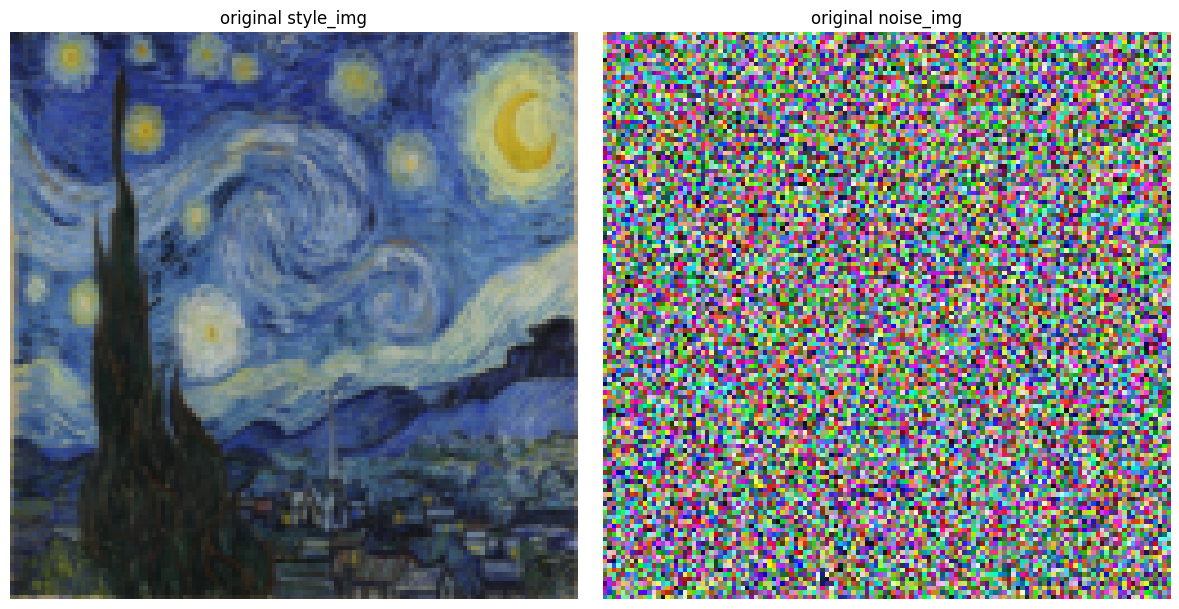

In [7]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(untransform(style_tensor.squeeze(0)))
plt.title(f"original style_img")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(untransform(noise_tensor.squeeze(0)))
plt.title(f"original noise_img")
plt.axis("off")

plt.tight_layout()
plt.show()

# 2. model

## 2.1. load pre-trained vgg19

In [8]:
vgg19_model = vgg19(weights=VGG19_Weights.DEFAULT).features.eval()

## 2.2. add normalization layer

In [9]:
ImageNet_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
ImageNet_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = mean.view(-1, 1, 1)
        self.std = std.view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

## 2.3. slice vgg19

In [10]:
model = nn.Sequential(Normalization(ImageNet_mean, ImageNet_std))
i = 0
for layer in vgg19_model.children():
    if isinstance(layer, nn.Conv2d):
        i += 1
        name = f"conv_{i}"
    elif isinstance(layer, nn.ReLU):
        layer = nn.ReLU(inplace=False) # inplace=True <- backprop error
        name = f"relu_{i}"
    elif isinstance(layer, nn.MaxPool2d):
        layer = nn.AvgPool2d(2, 2) # follow the paper
        name = f"pool_{i}"
    elif isinstance(layer, nn.BatchNorm2d):
        name = f"bn_{i}"

    model.add_module(name, layer)

    if name == f'conv_5':
        break

print(model)

Sequential(
  (0): Normalization()
  (conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_1): ReLU()
  (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_2): ReLU()
  (pool_2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv_3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_3): ReLU()
  (conv_4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_4): ReLU()
  (pool_4): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv_5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


## 2.4. visualize

In [11]:
def visualize_feature_maps(style_results, noise_results, 
                           layers=['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5'], title=""):
    fig, axes = plt.subplots(len(layers), 2, figsize=(10, 5 * len(layers)))
    fig.suptitle(title, fontsize=16)

    if len(layers) == 1:
        axes = [axes]

    for i, layer in enumerate(layers):
        # style feature map
        style_feature_map = style_results[layer].squeeze(0).cpu()
        style_mean_map = torch.mean(style_feature_map, dim=0).detach().numpy()
        axes[i][0].imshow(style_mean_map, cmap="viridis")
        axes[i][0].set_title(f"{layer} (Style)")
        axes[i][0].axis("off")

        # Noise feature map
        noise_feature_map = noise_results[layer].squeeze(0).cpu()
        noise_mean_map = torch.mean(noise_feature_map, dim=0).detach().numpy()
        axes[i][1].imshow(noise_mean_map, cmap="viridis")
        axes[i][1].set_title(f"{layer} (Noise)")
        axes[i][1].axis("off")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

In [12]:
model.eval()

style_feature_map = style_tensor.clone().to(device)
noise_feature_map = noise_tensor.clone().to(device)

style_feature_maps = {}
noise_feature_maps = {}

for name, layer in model.named_children():
    style_feature_map = layer(style_feature_map)
    style_feature_maps[name] = style_feature_map

    noise_feature_map = layer(noise_feature_map)
    noise_feature_maps[name] = noise_feature_map

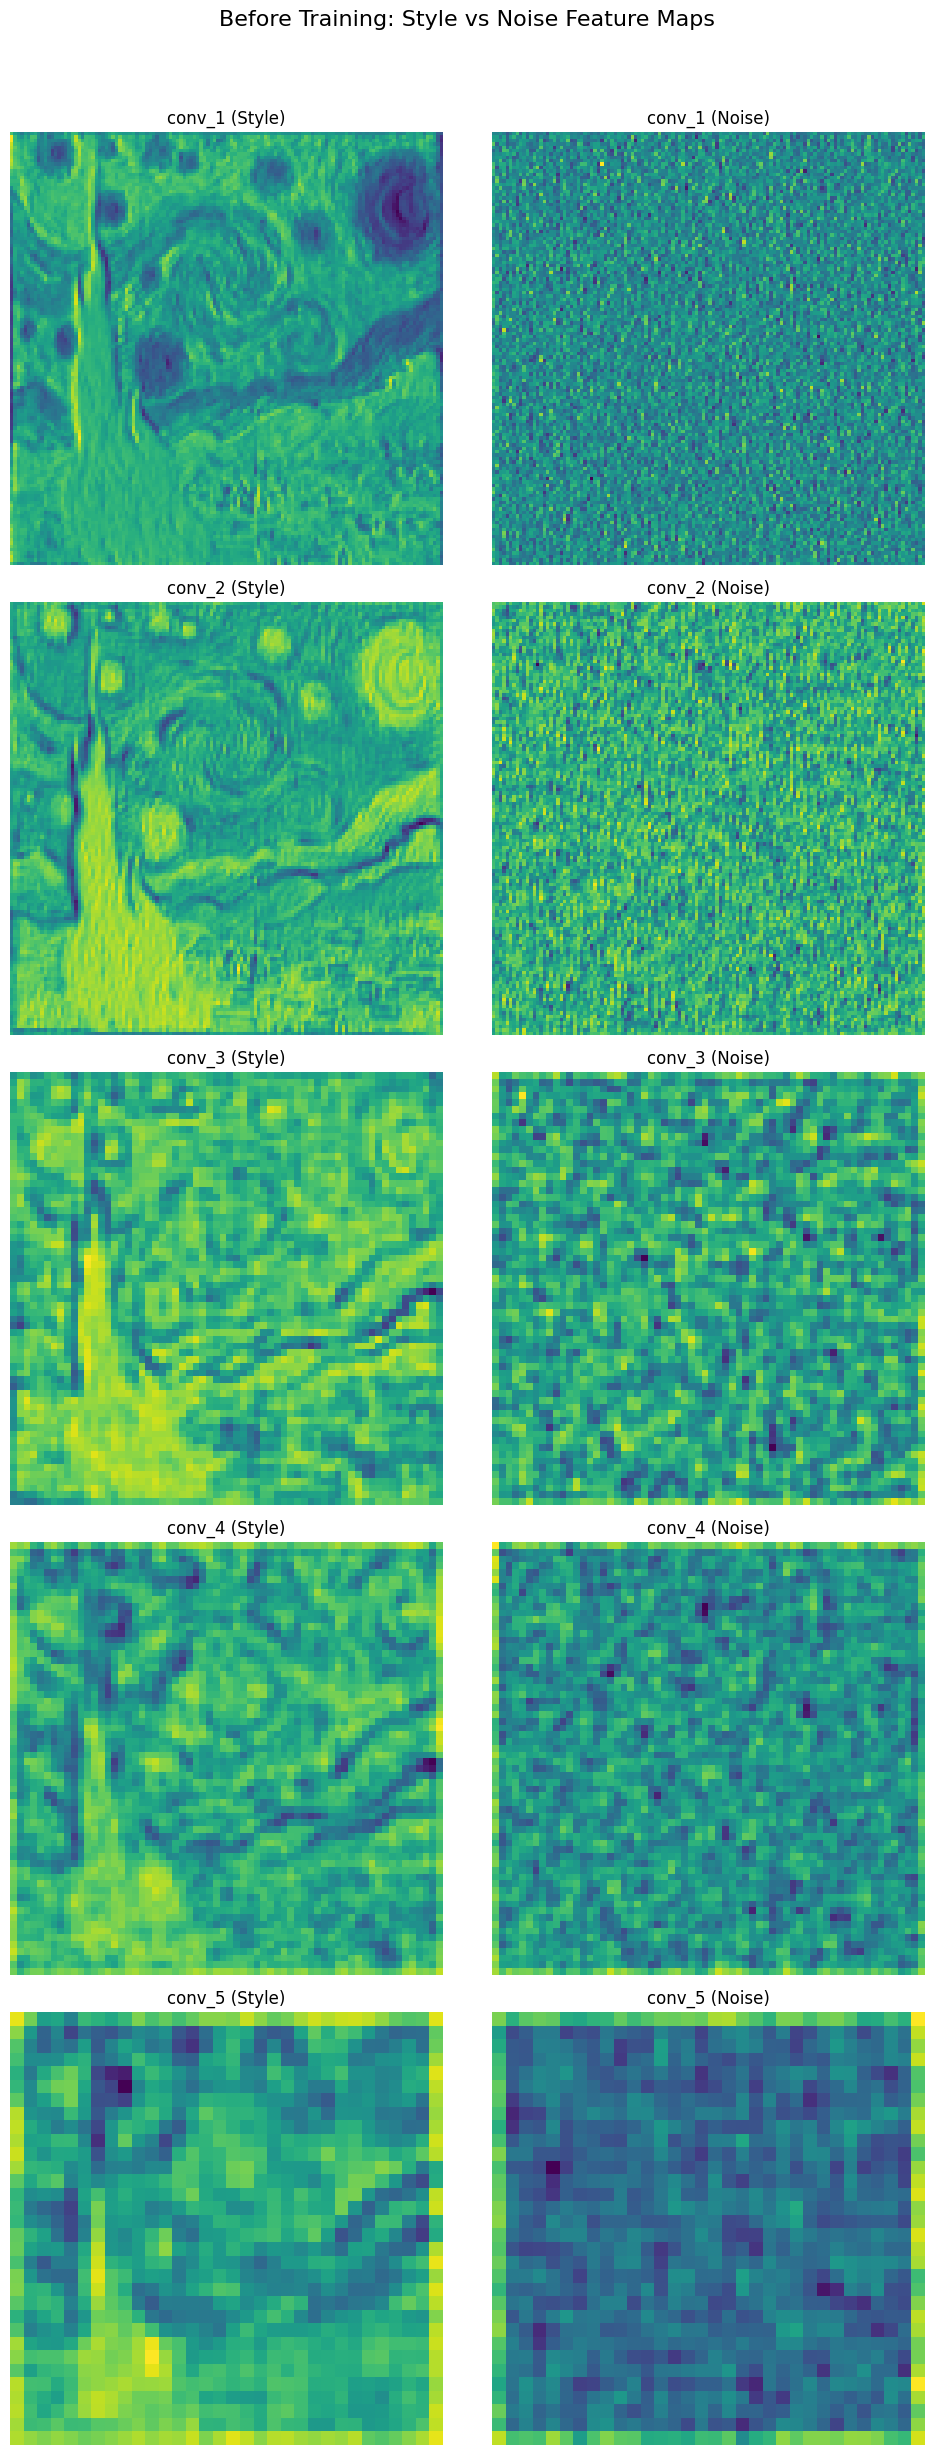

In [13]:
visualize_feature_maps(style_feature_maps, noise_feature_maps, title="Before Training: Style vs Noise Feature Maps")

# 3. loss

## 3.1. style-loss

## Gram Matrix 비유: 페인팅

### 페인트의 색상과 질감(채널)
- 화가가 그림을 그릴 때 사용한 다양한 **색상과 질감**이 그림의 스타일을 결정합니다.
- 피처맵의 각 채널은 그림의 특정 **색상이나 질감**을 표현한다고 생각할 수 있습니다.

### 색상 간의 관계
- 스타일은 단순히 어떤 색상이 쓰였는지가 아니라, **색상들 간의 관계와 조화**에서 나옵니다.
- 예를 들어:
  - **파란색과 노란색**이 부드럽게 섞이면 차분한 스타일.
  - **빨간색과 검은색**이 강하게 대조되면 강렬한 스타일.
- Gram Matrix는 이러한 **색상 간의 상관관계**를 수치적으로 캡처합니다.

### 그림의 위치 정보 제거
- 스타일은 그림의 구체적인 **위치**와 상관없이, 색상과 질감의 전반적인 **조화**로 정의됩니다.
- Gram Matrix는 위치 정보(공간적 구조)를 무시하고, 스타일의 본질인 **조화와 패턴**만 남깁니다.


In [14]:
def gram_matrix(feature_map):
    batch, channel, height, width = feature_map.size()

    features = feature_map.view(batch * channel, height * width)
    G = torch.mm(features, features.t())

    return G.div(batch * channel * height * width)

In [15]:
def style_loss(input, target):
    input_G = gram_matrix(input)
    target_G = gram_matrix(target)

    loss = F.mse_loss(input_G, target_G)

    return loss

# 4. train

## 4.1. training

In [16]:
model.eval()

style_feature_map = style_tensor.clone().to(device)

style_feature_maps = {}

for name, layer in model.named_children():
    style_feature_map = layer(style_feature_map)
    style_feature_maps[name] = style_feature_map

In [17]:
style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']


def train(model, style_feature_maps, epochs=300):
    required_noise_feature_map = noise_tensor.clone().to(device)
    required_noise_feature_map.requires_grad_(True)

    model.eval()
    model.requires_grad_(False)

    optimizer = optim.LBFGS([required_noise_feature_map])
    epoch = 0

    def closure():
        nonlocal epoch
        with torch.no_grad():
            required_noise_feature_map.clamp_(0, 1)
        output = required_noise_feature_map

        optimizer.zero_grad()
        style_losses = 0.0
        for name, layer in model.named_children():
            output = layer(output)

            if name in style_layers:
                style_losses += style_loss(output, style_feature_maps[name].detach())
        
        style_losses *= 1000000 # prevent overflow
        style_losses.backward()

        epoch += 1
        if epoch % 50 == 0:
            print(f"epoch {epoch}/{epochs}:")
            print(f"style-loss: {style_losses.item():.4f}")
            print()

        return style_losses
    
    while epoch <= epochs:
        optimizer.step(closure)

    with torch.no_grad():
        required_noise_feature_map.clamp_(0, 1)

    return required_noise_feature_map

required_noise_feature_map = train(model, style_feature_maps)

epoch 50/300:
style-loss: 4.6445

epoch 100/300:
style-loss: 1.5638

epoch 150/300:
style-loss: 0.7371

epoch 200/300:
style-loss: 0.3500

epoch 250/300:
style-loss: 0.2038

epoch 300/300:
style-loss: 0.1331



## 4.2. visualize

In [18]:
noise_feature_map = required_noise_feature_map
noise_feature_maps = {}

for name, layer in model.named_children():
    noise_feature_map = layer(noise_feature_map)
    noise_feature_maps[name] = noise_feature_map

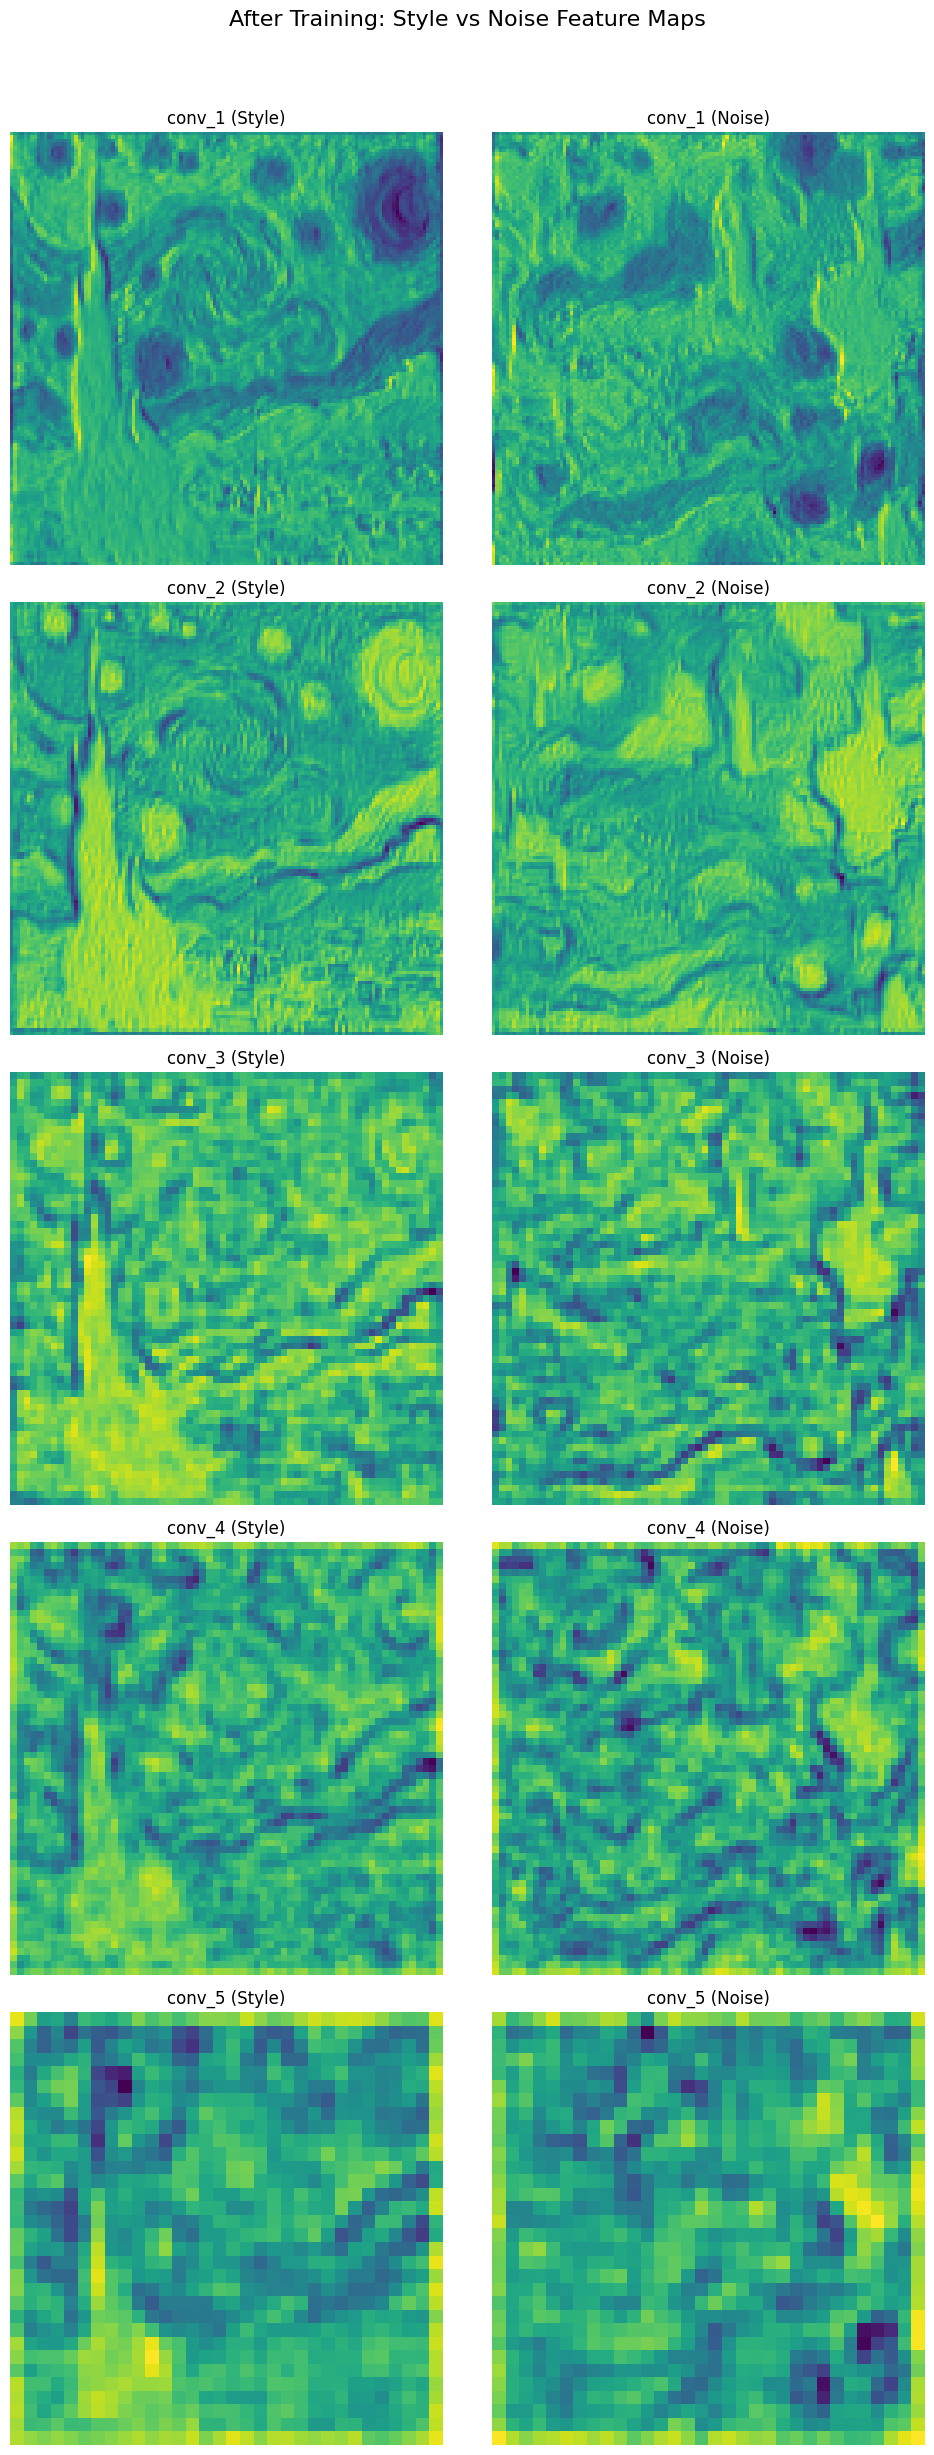

In [19]:
visualize_feature_maps(style_feature_maps, noise_feature_maps, title="After Training: Style vs Noise Feature Maps")

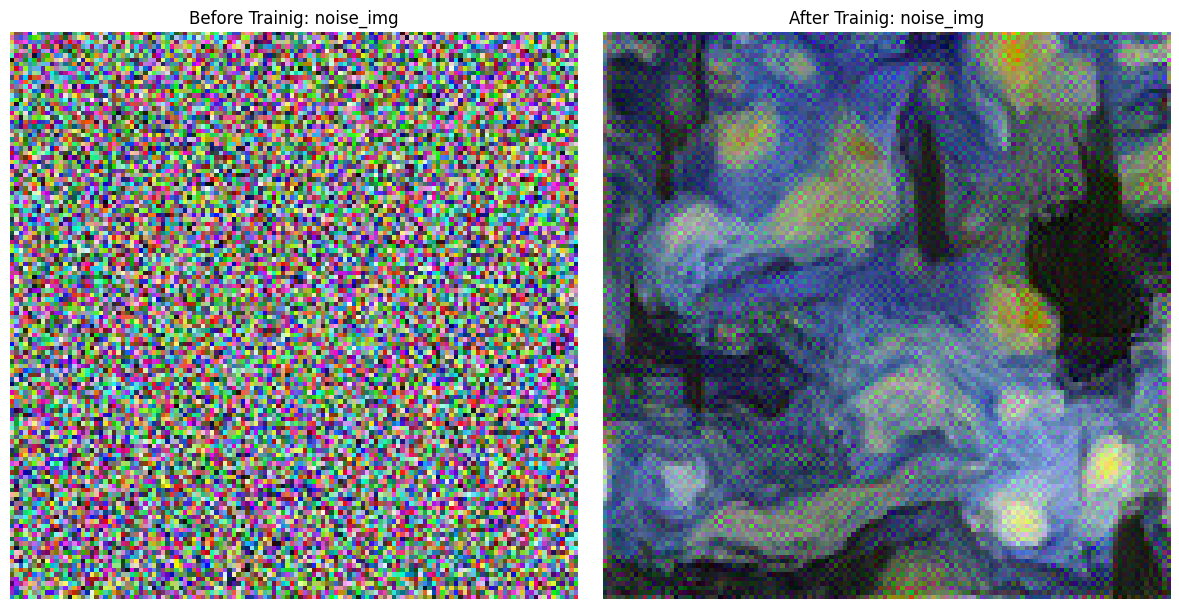

In [20]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(untransform(noise_tensor.squeeze(0)))
plt.title("Before Trainig: noise_img")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(untransform(required_noise_feature_map.squeeze(0)))
plt.title("After Trainig: noise_img")
plt.axis("off")

plt.tight_layout()
plt.show()